<h1 style="color:#2F659C";>Azog A4 measurement script</h1>
The cooled down chip is azog_a4, a resonators made of 1000 Dolan bridge junctions.

In [38]:
sample_name = 'azog_a4'              # name of the chip in the fridge

user = 'ncr'                         # who is performing measurements
date = '20211025'                    # when did the measurements started
description = 'resonator_dc'         # super short description of what you are doing

<h3 style="color:#418FDB";>QCodes imports</h3>
Import the QCodes functions used in the measurement of this sample.

In [39]:
import os
import sys
from time import sleep, perf_counter

import matplotlib.pyplot as plt
import numpy as np
import qcodes as qc
from qcodes import (
    Measurement,
    experiments,
    initialise_database,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_experiment,
    load_last_experiment,
    load_or_create_experiment,
    new_experiment,
)

#from qcodes.utils.dataset.doNd import do0d, do1d, do2d, dond, plot, LinSweep, LogSweep

from qcodes.dataset.plotting import plot_dataset
from qcodes.logger.logger import start_all_logging, start_command_history_logger
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.interactive_widget import experiments_widget

In [40]:
sys.path.append(r'C:\Users\nicolas.roch\Measurements\Scripts')

from QMETfunc.QMET_measurement import do0d, do1d, do2d, dond, LinSweep, LogSweep

<h2 style="color:#1C3C5C";>Station and database setup</h2>
Add the instruments to the station and start all the loggings related to the measurement. Then create or initialise the database where all the data will be saved.

In [41]:
data_dir = os.path.join(r'D:\QMET' + '\\' + sample_name)

<h3 style="color:#418FDB";>Station initialization</h3>

In [42]:
STATION = qc.Station()

start_all_logging()
start_command_history_logger(data_dir)

Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nicolas.roch\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nicolas.roch\.qcodes\logs\211025-22512-qcodes.log
Activating auto-logging. Current session state plus future input saved.
Filename       : D:\QMET\azog_a4\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


<h3 style="color:#418FDB";>Database initialization</h3>

In [43]:
database_name = date + '_' + user + '_' + description
try :
    os.mkdir(data_dir)
except FileExistsError:
    pass

qc.initialise_or_create_database_at(data_dir + '\\' + database_name + '.db')
qc.config.core.db_location

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 509.02it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.26it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 602.20it/s]


'D:\\QMET\\azog_a4\\20211025_ncr_resonator_dc.db'

<h3 style="color:#418FDB";>Instruments initialisation</h3>
Add to path the folder containing the drivers. Then import and connect to the used instruments, while delete the unused ones.

In [44]:
sys.path.append(r'C:\Users\nicolas.roch\Measurements\Drivers')

<h4  style="color:#4697E8";>Connect to the Rohde&Schwartz VNA</h4>

In [45]:
from VNA_RS import ZNB
#from VNA_ZNB20 import ZNB
#from VNA_ZNB20 import ZNBChannel

try:
    vna = ZNB('ZNB20', 'TCPIP0::192.168.0.9::inst0::INSTR',
               init_s_params=False,terminator='\n')
except KeyError as er:
    ZNB.close_all() # Disconnect and irreversibly tear down the instrument
    vna = ZNB('ZNB20', 'TCPIP0::192.168.0.9::inst0::INSTR',
               init_s_params=False,terminator='\n')
    
vna.clear_channels()

vna.add_channel('S21', vna_parameter='S21');
s21 = vna.channels.S21

#vna.add_channel('S11', vna_parameter='S11');
#s11 = vna.channels.S11

Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101579, firmware:2.94) in 0.06s


<h4 style="color:#4697E8";>Connect to the ADwin</h4>

In [30]:
from ADwin_Gold2 import ADwin_Gold2, adwin_Nramp

ad = ADwin_Gold2("adwin",
                 r"C:\Users\nicolas.roch\Measurements\Drivers\adwin\nanoqt\ressources\ADwin11.btl",
                 r"C:\Users\nicolas.roch\Measurements\Drivers\adwin\nanoqt\ressources\acquisition-gold2.TB1")

Connected to: None adwin (serial:None, firmware:None) in 0.25s


<h4 style="color:#4697E8";>Connect to the Agilent signal generator</h4>

In [46]:
from Agilent_E8257D import E8257D

try:
    mw_source = E8257D('mw_source','TCPIP0::192.168.0.70::inst0::INSTR')
except KeyError as er:
    E8257D.close_all()
    mw_source = E8257D('mw_source','TCPIP0::192.168.0.70::inst0::INSTR')

Connected to: Agilent Technologies E8257D (serial:US45470698, firmware:C.06.28) in 0.03s


<h4 style="color:#4697E8";>Connect to the Rohde&Schwartz signal generator</h4>

In [47]:
from RS_SMB_100A import SMB100A

#try:
#    mw_source_rs = SGS100A('pump_source','USB0::0x0AAD::0x0088::112061::INSTR')
#except KeyError as er:
#    SGS100A.close_all()
#    mw_source_rs = SGS100A('pump_source','USB0::0x0AAD::0x0088::112061::INSTR')

<h4 style="color:#4697E8";>Dummies</h4>

In [48]:
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)

<h3 style="color:#418FDB";>Adding the instruments to the station</h3>

In [49]:
STATION.add_component(s21)         # VNA channel s21
STATION.add_component(mw_source)   # Signal generator
STATION.add_component(ad)          # ADwin
#STATION.add_component(daq)        # Dummy signal
#STATION.add_component(dmm)        # Dummy multimeter

STATION.snapshot();
STATION.components

2021-10-25 18:01:05,529 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [ZNB20_S21(VNAChannel)] Snapshot: Could not update parameter: trigger_link
2021-10-25 18:01:10,660 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [mw_source(E8257D)] Snapshot: Could not update parameter: sweepmode


{'ZNB20_S21': <VNAChannel: ZNB20_S21 of ZNB: ZNB20>,
 'mw_source': <E8257D: mw_source>}

<h2 style="color:#1C3C5C";>Measurements</h2>
Here the idea is to create a new cell and a new experiment every time something more that just ranges and parameters are changed. Every new measurement will be stored in the database with a different experiment name, so it's easyer to retrive. Note that the used instruments must be initialised before, in the Instrument Initialisation section.

<h3 style="color:#418FDB";>Microwave measurements with the VNA</h3>

<h4  style="color:#4697E8";>Phase and magnitude of the current trace</h4>

Starting experimental run with id: 2. Using 'qcodes.utils.dataset.doNd.do0d'


2

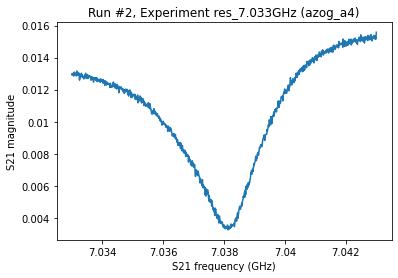

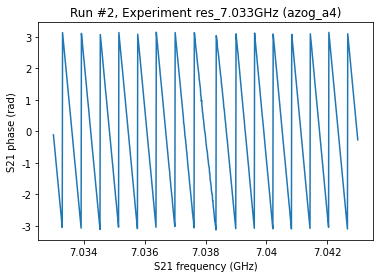

In [51]:
experiment_name = 'res_7.033GHz'
measurement_name = 'vna_s21_trace'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

s21.center(7.038e9)
s21.npts(1001)
s21.span(10e6)
s21.bandwidth(1e3)
s21.averaging_enabled(True)
s21.avg(10)
s21.power(-30)

s21.set_electrical_delay_auto()
s21.average_clear()

vna.rf_on()
res = do0d(s21.trace_mag_phase, measurement_name=measurement_name);
vna.rf_off()

res[0].captured_run_id

<h4  style="color:#4697E8";>Phase and magnitude of traces corresponding to different power levels</h4>

Starting experimental run with id: 4. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/10 [00:00<?, ?it/s]

4

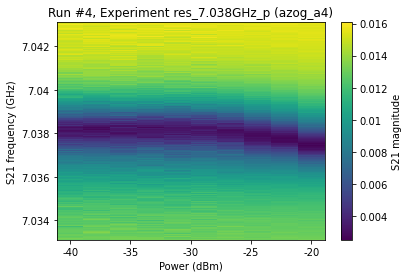

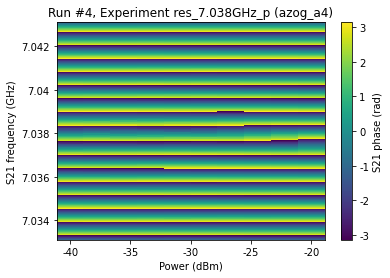

In [53]:
experiment_name = 'res_7.038GHz_p'
measurement_name = 'supercool_2d_vna'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

s21.center(7.0381e9)
s21.npts(1001)
s21.span(10e6)
s21.bandwidth(1e3)
s21.averaging_enabled(False)
s21.avg(2)
s21.power(-30)
s21.set_electrical_delay_auto()

vna.rf_on()
res = do1d(s21.power, -40, -20, 10, 0.01, s21.trace_mag_phase, measurement_name=measurement_name);
vna.rf_off()

res[0].captured_run_id

<h3 style="color:#418FDB";>Microwave measurement with VNA and signal generator</h3>

Starting experimental run with id: 123. Using 'qcodes.utils.dataset.doNd.do1d'


  0%|          | 0/11 [00:00<?, ?it/s]

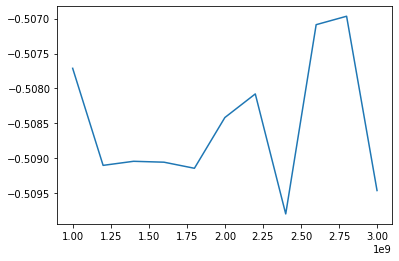

In [17]:
experiment_name = 'test_experiment_vna_mw'
measurement_name = 'supercool_vna_cw'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

#set the vna parameters
s21.center(2e9)
s21.npts(1)
s21.bandwidth(1e3)
#s21.span(1e3)
s21.averaging_enabled(True)
s21.avg(10)
s21.power(-30)
#s21.set_electrical_delay_auto()

# set the signal generator parameters
mw_source.sourcemode('CW')
mw_source.power(-20)
mw_source.phase(0)

# WARNING! It takes too much time for some reasons
vna.rf_on()
mw_source.status('ON')
res = do1d(mw_source.frequency, 1e9, 3e9, 11, 0.01, s21.trace_mag_phase, measurement_name=measurement_name, do_plot=False);
mw_source.status('OFF')
vna.rf_off()

# maybe it would be good to improve the plotting of the results
runID = res[0].captured_run_id
x = res[0].get_parameter_data('mw_source_frequency')['mw_source_frequency']['mw_source_frequency']
y = res[0].get_parameter_data('ZNB20_S21_phase')['ZNB20_S21_phase']['ZNB20_S21_phase']
plt.plot(x[::2], y)

# add function that creates a measurements log file

<h4  style="color:#4697E8";>VNA CW and signal generator power and frequency sweep (two tones spectroscopy)</h4>

In [54]:
experiment_name = 'two_tones_7.038'
measurement_name = 'meas_7.038_tone_0.1_30'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

#set the vna parameters
s21.npts(1)
s21.bandwidth(1e2)
s21.center(7.0381e9)
#s21.span(1e3)
s21.averaging_enabled(True)
s21.avg(2)
s21.power(-30)
#s21.set_electrical_delay_auto()

# set the signal generator parameters
mw_source.sourcemode('CW')
mw_source.phase(0)

start_frequency = 10e9
stop_frequency = 20e9
step_frequency = .5e6
frequency_points = int( (stop_frequency-start_frequency)/step_frequency )

start_power = -30
stop_power = 0
step_power = 1.0
power_points = int( (stop_power-start_power)/step_power )

dwell_time = 0.005

# WARNING! It takes too much time for some reasons
vna.rf_on()
mw_source.status('ON')
res = do2d(mw_source.power, start_power, stop_power, power_points, 100*dwell_time,
           mw_source.frequency, start_frequency, stop_frequency, frequency_points, dwell_time, 
           s21.trace_mag_phase, measurement_name=measurement_name, do_plot=False);
mw_source.status('OFF')
vna.rf_off()

# maybe it would be good to improve the plotting of the results
#runID = res[0].captured_run_id
#x = res[0].get_parameter_data('mw_source_frequency')['mw_source_frequency']['mw_source_frequency']
#y = res[0].get_parameter_data('ZNB20_S21_phase')['ZNB20_S21_phase']['ZNB20_S21_phase']
#plt.plot(x[::2], y)

# add function that creates a measurements log file

Starting experimental run with id: 5. Using 'qcodes.utils.dataset.doNd.do2d'


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

<h3  style="color:#418FDB";>Microwave and DC measurements</h3>

<h4 style="color:#4697E8";>Only ADwin</h4>

In [18]:
experiment_name = 'test_experiment_adwin'
measurement_name = 'supercool_this_adwin'
exp = load_or_create_experiment(experiment_name=experiment_name, sample_name=sample_name)

#set the adwin parameters


<h4  style="color:#4697E8";>Adwin and microwave signal generator</h4>

<h2 style="color:#1C3C5C";>Data preview</h2>
Using the experiments widget to look at all the measurements in the database, or filter them by experiment.

In [ ]:
experiments = qc.experiments()                       # define the experiments
#data_sets = experiments[6].data_sets()               # selecto only one experiment
#experiments_widget(data_sets=data_sets)              # start the widget on the selected experiment

experiments_widget(db=qc.config.core.db_location)  # start the widget on the whole database